Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [9]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
import warnings
warnings.filterwarnings("ignore")

# Some personnal imports
import matplotlib.pyplot as plt
%matplotlib inline

First reload the data we generated in `1_notmnist.ipynb`.

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10 # 0, 1, ..., 9, image of number

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)

  # float 1-hot encodings: Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:, None]).astype(np.float32)

  return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)

print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [4]:
def accuracy(predictions, labels):
    
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both **logistic** and **neural network** models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

- Logistic Model

In [5]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # 1 Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))

  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  beta_regul = tf.placeholder(tf.float32)
  
    
  # 2 Variables.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
    
  biases = tf.Variable(tf.zeros([num_labels]))
  
    
  # 3 Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases
    
  loss = tf.reduce_mean( # L2 penalty (Note: should specify arguments in softmax_cross_entropy_with_logits)
    tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = tf_train_labels)) \
                                            + beta_regul * tf.nn.l2_loss(weights)
  
    
  # 4 Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  

  # 5 Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

Now let's train the model.

In [6]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
    
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : 1e-3}
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict = feed_dict)
    
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Minibatch loss at step 0: 23.509336
Minibatch accuracy: 3.1%
Validation accuracy: 10.5%
Minibatch loss at step 500: 2.951400
Minibatch accuracy: 78.1%
Validation accuracy: 76.1%
Minibatch loss at step 1000: 1.703904
Minibatch accuracy: 78.1%
Validation accuracy: 78.1%
Minibatch loss at step 1500: 1.052881
Minibatch accuracy: 81.2%
Validation accuracy: 79.5%
Minibatch loss at step 2000: 1.208335
Minibatch accuracy: 76.6%
Validation accuracy: 80.9%
Minibatch loss at step 2500: 0.527465
Minibatch accuracy: 90.6%
Validation accuracy: 81.2%
Minibatch loss at step 3000: 0.826048
Minibatch accuracy: 80.5%
Validation accuracy: 81.0%
Test accuracy: 88.5%


The L2 regularization introduces a new meta parameter that should be tuned. Since I do not have any idea of what should be the right value for this meta parameter, I will plot the accuracy by the meta parameter value (in a logarithmic scale).

In [7]:
num_steps = 3001
regul_val = [pow(10, i) for i in np.arange(-4, -2, 0.1)]
accuracy_val = []

for regul in regul_val:
  with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
      offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        
    # Generate a minibatch.
      batch_data = train_dataset[offset:(offset + batch_size), :]
      batch_labels = train_labels[offset:(offset + batch_size), :]
    
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
      feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : regul}
      _, l, predictions = session.run(
        [optimizer, loss, train_prediction], feed_dict=feed_dict)
    accuracy_val.append(accuracy(test_prediction.eval(), test_labels))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Instructions for updating:
Use `tf.glo

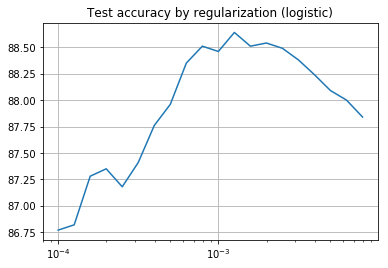

In [10]:
plt.semilogx(regul_val, accuracy_val)
plt.grid(True)
plt.title('Test accuracy by regularization (logistic)')
plt.show()

- 1-layer neural network using same technique

In [12]:
batch_size = 128
num_hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():

  # 1 Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32, shape = (batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape = (batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  beta_regul = tf.placeholder(tf.float32)
  
    
  # 2 Variables.
  weights1 = tf.Variable(tf.truncated_normal([image_size * image_size, num_hidden_nodes]))
  biases1 = tf.Variable(tf.zeros([num_hidden_nodes]))

  weights2 = tf.Variable(tf.truncated_normal([num_hidden_nodes, num_labels]))
  biases2 = tf.Variable(tf.zeros([num_labels]))
  
    
  # 3 Training computation (L2 norm)
  lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
  logits = tf.matmul(lay1_train, weights2) + biases2
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = tf_train_labels)) + \
      beta_regul * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2))
  

  # 4 Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
    
  # 5 Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
  valid_prediction = tf.nn.softmax(tf.matmul(lay1_valid, weights2) + biases2)
  lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
  test_prediction = tf.nn.softmax(tf.matmul(lay1_test, weights2) + biases2)

Let's train the 1-layer neural network model and print the results. It may take a long time.

In [13]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
    
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : 1e-3}
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict = feed_dict)
    
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Minibatch loss at step 0: 631.116211
Minibatch accuracy: 20.3%
Validation accuracy: 31.3%
Minibatch loss at step 500: 193.898865
Minibatch accuracy: 80.5%
Validation accuracy: 80.1%
Minibatch loss at step 1000: 115.514580
Minibatch accuracy: 77.3%
Validation accuracy: 78.6%
Minibatch loss at step 1500: 68.680923
Minibatch accuracy: 84.4%
Validation accuracy: 83.0%
Minibatch loss at step 2000: 41.756123
Minibatch accuracy: 79.7%
Validation accuracy: 84.6%
Minibatch loss at step 2500: 25.030838
Minibatch accuracy: 95.3%
Validation accuracy: 85.9%
Minibatch loss at step 3000: 15.545663
Minibatch accuracy: 88.3%
Validation accuracy: 86.5%
Test accuracy: 93.0%


Finally something above 90%! I will also plot the final accuracy by the L2 parameter to find the best value. It may take much more time than before. (电脑会呼呼作响)

In [14]:
num_steps = 3001
regul_val = [pow(10, i) for i in np.arange(-4, -2, 0.1)]
accuracy_val = []

for regul in regul_val:    
  with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    for step in range(num_steps):
      # Pick an offset within the training data, which has been randomized.
      # Note: we could use better randomization across epochs.
      offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    
      # Generate a minibatch.
      batch_data = train_dataset[offset:(offset + batch_size), :]
      batch_labels = train_labels[offset:(offset + batch_size), :]
        
      # Prepare a dictionary telling the session where to feed the minibatch.
      # The key of the dictionary is the placeholder node of the graph to be fed,
      # and the value is the numpy array to feed to it.
      feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : regul}
      _, l, predictions = session.run(
        [optimizer, loss, train_prediction], feed_dict=feed_dict)
    accuracy_val.append(accuracy(test_prediction.eval(), test_labels))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Instructions for updating:
Use `tf.glo

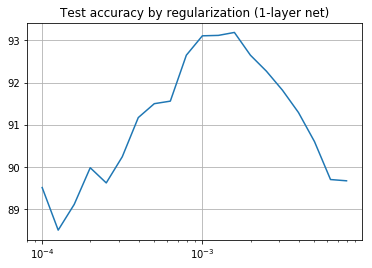

In [15]:
plt.semilogx(regul_val, accuracy_val)
plt.grid(True)
plt.title('Test accuracy by regularization (1-layer net)')
plt.show()

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [16]:
batch_size = 128
num_hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():

  # 1 Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32, shape = (batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape = (batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  beta_regul = tf.placeholder(tf.float32)
  
    
  # 2 Variables.
  weights1 = tf.Variable(tf.truncated_normal([image_size * image_size, num_hidden_nodes]))
  biases1 = tf.Variable(tf.zeros([num_hidden_nodes]))

  weights2 = tf.Variable(tf.truncated_normal([num_hidden_nodes, num_labels]))
  biases2 = tf.Variable(tf.zeros([num_labels]))
  
    
  # 3 Training computation.
  lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
  logits = tf.matmul(lay1_train, weights2) + biases2
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = tf_train_labels))
  

  # 4 Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
    
  # 5 Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
  valid_prediction = tf.nn.softmax(tf.matmul(lay1_valid, weights2) + biases2)
  lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
  test_prediction = tf.nn.softmax(tf.matmul(lay1_test, weights2) + biases2)

In [17]:
num_steps = 101 # decrease this number
num_bacthes = 3

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
    
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    #offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    offset = step % num_bacthes
    
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : 1e-3}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    
    if (step % 2 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Minibatch loss at step 0: 307.827240
Minibatch accuracy: 9.4%
Validation accuracy: 27.0%
Minibatch loss at step 2: 1321.388184
Minibatch accuracy: 46.1%
Validation accuracy: 41.3%
Minibatch loss at step 4: 120.429474
Minibatch accuracy: 77.3%
Validation accuracy: 56.7%
Minibatch loss at step 6: 9.355587
Minibatch accuracy: 96.1%
Validation accuracy: 62.6%
Minibatch loss at step 8: 7.533780
Minibatch accuracy: 96.9%
Validation accuracy: 62.4%
Minibatch loss at step 10: 4.323696
Minibatch accuracy: 98.4%
Validation accuracy: 62.5%
Minibatch loss at step 12: 3.719761
Minibatch accuracy: 98.4%
Validation accuracy: 62.5%
Minibatch loss at step 14: 3.167106
Minibatch accuracy: 98.4%
Validation accuracy: 62.4%
Minibatch loss at step 16: 2.658126
Minibatch accuracy: 98.4%
Validation accuracy: 62.4%
Minibatch loss at step 18: 2.146497
Minibatch accuracy: 98.4%
Validation accuracy: 62.4%
Minibatch loss at step 

Since there are far too much parameters and no regularization, the accuracy of the batches is 100%. **The generalization capability is poor**, as shown in the validation and test accuracy.

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [20]:
batch_size = 128
num_hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():

  # 1 Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  

  # 2 Variables.
  weights1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_hidden_nodes]))
  biases1 = tf.Variable(tf.zeros([num_hidden_nodes]))
  weights2 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes, num_labels]))
  biases2 = tf.Variable(tf.zeros([num_labels]))
  

  # 3 Training computation.
  lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
  drop1 = tf.nn.dropout(lay1_train, 0.5) # add dropout to our training
  logits = tf.matmul(drop1, weights2) + biases2
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = tf_train_labels))
    
    
  # 4 Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  

  # 5 Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
  valid_prediction = tf.nn.softmax(tf.matmul(lay1_valid, weights2) + biases2)
  lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
  test_prediction = tf.nn.softmax(tf.matmul(lay1_test, weights2) + biases2)

In [21]:
num_steps = 101
num_batches = 3

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    #offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    
    offset = step % num_batches
    
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    
    if (step % 2 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
    
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Minibatch loss at step 0: 448.274292
Minibatch accuracy: 10.9%
Validation accuracy: 24.4%
Minibatch loss at step 2: 1192.446777
Minibatch accuracy: 49.2%
Validation accuracy: 31.9%
Minibatch loss at step 4: 238.649506
Minibatch accuracy: 70.3%
Validation accuracy: 47.6%
Minibatch loss at step 6: 170.111343
Minibatch accuracy: 82.8%
Validation accuracy: 61.7%
Minibatch loss at step 8: 9.548517
Minibatch accuracy: 96.1%
Validation accuracy: 64.8%
Minibatch loss at step 10: 8.609098
Minibatch accuracy: 95.3%
Validation accuracy: 66.2%
Minibatch loss at step 12: 8.126238
Minibatch accuracy: 96.9%
Validation accuracy: 67.6%
Minibatch loss at step 14: 2.995707
Minibatch accuracy: 97.7%
Validation accuracy: 67.3%
Minibatch loss at step 16: 5.602012
Minibatch accuracy: 96.9%
Validation accuracy: 65.0%
Minibatch loss at step 18: 5.971211
Minibatch accuracy: 96.1%
Validation accuracy: 64.7%
Minibatch loss at st

The first conclusion is that 100% of accuracy on the minibatches is more difficult achieved or to keep. As a result, the test accuracy is improved by 6%, the final net is more capable of generalization.

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


Let's first try 2-layer network. Note how the parameters are initialized, compared to the previous cases.

In [22]:
batch_size = 128
num_hidden_nodes1 = 1024
num_hidden_nodes2 = 100
beta_regul = 1e-3

graph = tf.Graph()
with graph.as_default():

  # 1 Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  global_step = tf.Variable(0) # count the number of steps taken


  # 2 Variables.
  weights1 = tf.Variable(
    tf.truncated_normal(
        [image_size * image_size, num_hidden_nodes1],
        stddev=np.sqrt(2.0 / (image_size * image_size)))
    )
  biases1 = tf.Variable(tf.zeros([num_hidden_nodes1]))
    
  weights2 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes1, num_hidden_nodes2], stddev=np.sqrt(2.0 / num_hidden_nodes1)))
  biases2 = tf.Variable(tf.zeros([num_hidden_nodes2]))
    
  weights3 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes2, num_labels], stddev=np.sqrt(2.0 / num_hidden_nodes2)))
  biases3 = tf.Variable(tf.zeros([num_labels]))
  

  # 3 Training computation.
  lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
  lay2_train = tf.nn.relu(tf.matmul(lay1_train, weights2) + biases2)
  logits = tf.matmul(lay2_train, weights3) + biases3
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = tf_train_labels)) + \
      beta_regul * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2) + tf.nn.l2_loss(weights3))
  

  # 4 Optimizer.
    # learning rate
  learning_rate = tf.train.exponential_decay(0.5, global_step, 1000, 0.65, staircase = True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step = global_step)
  

  # 5 Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
  lay2_valid = tf.nn.relu(tf.matmul(lay1_valid, weights2) + biases2)
  valid_prediction = tf.nn.softmax(tf.matmul(lay2_valid, weights3) + biases3)
  lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
  lay2_test = tf.nn.relu(tf.matmul(lay1_test, weights2) + biases2)
  test_prediction = tf.nn.softmax(tf.matmul(lay2_test, weights3) + biases3)

In [23]:
num_steps = 9001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
    
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
    
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Minibatch loss at step 0: 3.368782
Minibatch accuracy: 8.6%
Validation accuracy: 26.0%
Minibatch loss at step 500: 1.009399
Minibatch accuracy: 84.4%
Validation accuracy: 85.4%
Minibatch loss at step 1000: 0.868829
Minibatch accuracy: 85.2%
Validation accuracy: 86.5%
Minibatch loss at step 1500: 0.643913
Minibatch accuracy: 89.1%
Validation accuracy: 87.5%
Minibatch loss at step 2000: 0.795483
Minibatch accuracy: 85.9%
Validation accuracy: 87.7%
Minibatch loss at step 2500: 0.405569
Minibatch accuracy: 96.9%
Validation accuracy: 88.9%
Minibatch loss at step 3000: 0.619974
Minibatch accuracy: 86.7%
Validation accuracy: 88.8%
Minibatch loss at step 3500: 0.543180
Minibatch accuracy: 89.8%
Validation accuracy: 89.2%
Minibatch loss at step 4000: 0.618144
Minibatch accuracy: 83.6%
Validation accuracy: 89.7%
Minibatch loss at step 4500: 0.407751
Minibatch accuracy: 93.8%
Validation accuracy: 89.7%
Minibatch

This is getting really good 95.6%. Let's try one layer deeper(3-layer network) with dropouts.

In [24]:
batch_size = 128
num_hidden_nodes1 = 1024
num_hidden_nodes2 = 256 # we can try different parameters here
num_hidden_nodes3 = 128
keep_prob = 0.5

graph = tf.Graph()
with graph.as_default():

  # 1 Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  global_step = tf.Variable(0)


  # 2 Variables.
  weights1 = tf.Variable(
    tf.truncated_normal(
        [image_size * image_size, num_hidden_nodes1],
        stddev=np.sqrt(2.0 / (image_size * image_size)))
    )
  biases1 = tf.Variable(tf.zeros([num_hidden_nodes1]))
    
  weights2 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes1, num_hidden_nodes2], stddev=np.sqrt(2.0 / num_hidden_nodes1)))
  biases2 = tf.Variable(tf.zeros([num_hidden_nodes2]))
    
  weights3 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes2, num_hidden_nodes3], stddev=np.sqrt(2.0 / num_hidden_nodes2)))
  biases3 = tf.Variable(tf.zeros([num_hidden_nodes3]))
    
  weights4 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes3, num_labels], stddev=np.sqrt(2.0 / num_hidden_nodes3)))
  biases4 = tf.Variable(tf.zeros([num_labels]))
  

  # 3 Training computation.
  lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
  lay2_train = tf.nn.relu(tf.matmul(lay1_train, weights2) + biases2)
  lay3_train = tf.nn.relu(tf.matmul(lay2_train, weights3) + biases3)
  logits = tf.matmul(lay3_train, weights4) + biases4
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = tf_train_labels))
  
    
  # 4 Optimizer.
  learning_rate = tf.train.exponential_decay(0.5, global_step, 4000, 0.65, staircase = True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step = global_step)
  
    
  # 5 Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
  lay2_valid = tf.nn.relu(tf.matmul(lay1_valid, weights2) + biases2)
  lay3_valid = tf.nn.relu(tf.matmul(lay2_valid, weights3) + biases3)
  valid_prediction = tf.nn.softmax(tf.matmul(lay3_valid, weights4) + biases4)
  lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
  lay2_test = tf.nn.relu(tf.matmul(lay1_test, weights2) + biases2)
  lay3_test = tf.nn.relu(tf.matmul(lay2_test, weights3) + biases3)
  test_prediction = tf.nn.softmax(tf.matmul(lay3_test, weights4) + biases4)

In [25]:
num_steps = 18001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
    
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
    
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Minibatch loss at step 0: 2.427080
Minibatch accuracy: 7.0%
Validation accuracy: 34.5%
Minibatch loss at step 500: 0.432839
Minibatch accuracy: 85.2%
Validation accuracy: 85.8%
Minibatch loss at step 1000: 0.404058
Minibatch accuracy: 85.9%
Validation accuracy: 87.2%
Minibatch loss at step 1500: 0.369126
Minibatch accuracy: 87.5%
Validation accuracy: 87.5%
Minibatch loss at step 2000: 0.485151
Minibatch accuracy: 86.7%
Validation accuracy: 87.7%
Minibatch loss at step 2500: 0.193783
Minibatch accuracy: 94.5%
Validation accuracy: 88.5%
Minibatch loss at step 3000: 0.351544
Minibatch accuracy: 89.1%
Validation accuracy: 88.6%
Minibatch loss at step 3500: 0.295934
Minibatch accuracy: 90.6%
Validation accuracy: 89.3%
Minibatch loss at step 4000: 0.414581
Minibatch accuracy: 87.5%
Validation accuracy: 89.0%
Minibatch loss at step 4500: 0.212324
Minibatch accuracy: 92.2%
Validation accuracy: 90.0%
Minibatch

We can get a pretty good result. We can also try more parameters as I comment in the cell.